## Conversational RAG

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [3]:
from typing import List
from haystack.utils import Secret
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage

In [4]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()


converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"converter": {"sources": ["../data/tolkien.txt",
                                                 "../data/George_RR_Martin.txt"]}})

No abbreviations file found for en. Using default abbreviations.
Batches: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


{'writer': {'documents_written': 92}}

In [5]:
document_store.count_documents()

92

### Create an OpenAIChatGenerator
The [`OpenAIChatGenerator`](https://docs.haystack.deepset.ai/docs/openaichatgenerator?utm_campaign=developer-relations&utm_source=dlai) allows chat completions using OpenAI LLMs. 

Messages can come from the following roles:
- system
- assistant
- user

In [6]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))
replies = chat_generator.run(messages=[ChatMessage.from_user("What was written by George Martin?")])

In [7]:
rich.print(replies['replies'][0])

ChatMessage(
    _role=<ChatRole.ASSISTANT: 'assistant'>,
    _content=[
        TextContent(
            text='George R. R. Martin is best known for his epic fantasy series "A Song of Ice and Fire," which 
inspired the hugely popular television series "Game of Thrones." The series includes the following main 
novels:\n\n1. **A Game of Thrones** (1996)\n2. **A Clash of Kings** (1998)\n3. **A Storm of Swords** (2000)\n4. **A
Feast for Crows** (2005)\n5. **A Dance with Dragons** (2011)\n\nAdditionally, he is working on two forthcoming 
books in the series: "The Winds of Winter" and "A Dream of Spring."\n\nMartin has also written other works, 
including:\n\n- **The Wild Cards** series (edited and contributed to)\n- Various short stories and collections, 
such as "Sandkings" and "Songs of Stars and Shadows"\n- Novels like "Dying of the Light" (1977) and "Fevre Dream" 
(1982)\n- Non-fiction works and screenplays, particularly for television shows such as "The Twilight Zone" and 
"Beauty and the Beast."\n\nHe has received numerous awards for his contributions to literature and television in 
the fantasy genre.'
        )
    ],
    _name=None,
    _meta={
        'model': 'gpt-4o-mini-2024-07-18',
        'index': 0,
        'finish_reason': 'stop',
        'usage': {
            'completion_tokens': 243,
            'prompt_tokens': 14,
            'total_tokens': 257,
            'completion_tokens_details': CompletionTokensDetails(
                accepted_prediction_tokens=0,
                audio_tokens=0,
                reasoning_tokens=0,
                rejected_prediction_tokens=0
            ),
            'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)
        }
    }
)

In [8]:
from haystack.components.converters import OutputAdapter

In [9]:
system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered exclusive from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.text }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

user_message = ChatMessage.from_user(user_message_template)

In [10]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.text }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

In [11]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


chat_agent = Pipeline()
chat_agent.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
chat_agent.add_component("query_rephrase_llm", OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))
chat_agent.add_component("query_embedder", SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
chat_agent.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3))
chat_agent.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
chat_agent.add_component("generator", chat_generator)




chat_agent.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
chat_agent.connect("query_rephrase_llm.replies", "list_to_str_adapter")
chat_agent.connect("list_to_str_adapter.output", "query_embedder.text")
chat_agent.connect("query_embedder.embedding", "retriever.query_embedding")

# connections for RAG
chat_agent.connect("retriever.documents", "prompt_builder.documents")
chat_agent.connect("prompt_builder.prompt", "generator.messages")





🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> query_embedder.text (str)
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])

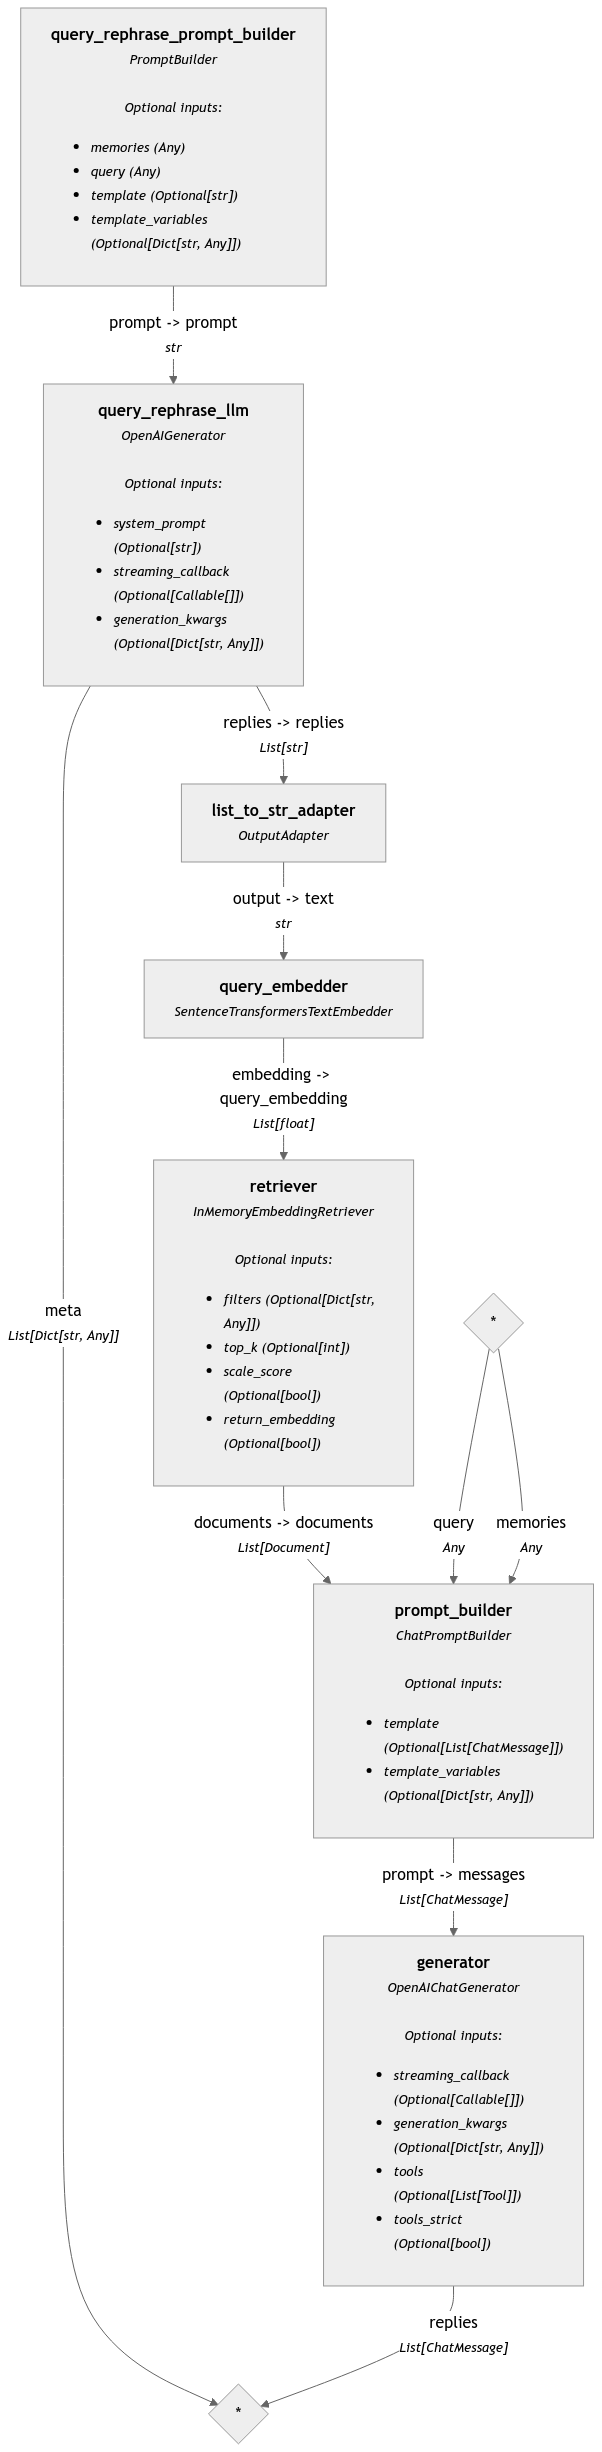

In [12]:
chat_agent.show()

In [13]:
messages = []
template = [system_message, user_message]
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    print(user_input)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    response = chat_agent.run({"query_rephrase_prompt_builder": {"query": user_input, "memories":messages}, 
                               "prompt_builder": {"template":template, "query": user_input, "memories":messages},},
                                include_outputs_from={"query_rephrase_llm", "message_collector", "generator"})
    messages.append(ChatMessage.from_user(user_input))
    messages.extend(response['generator']['replies'])
    print(response['query_rephrase_llm']['replies'][0])
    print(response['generator']['replies'][0].text)




Who is Tolkien?


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s]


Who is J.R.R. Tolkien?
John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is a highly influential and celebrated author in the high fantasy genre.
what did he write?


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.83it/s]


What works did Tolkien produce?
Tolkien wrote novels, including The Hobbit, as well as essays and letters discussing his creative process and the philosophical foundations of his work.
what's the main topic of the last book


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]


what is the main topic of Tolkien's last book?
The conversation history and supporting documents do not provide specific information about the main topic of Tolkien's last book.
what's the topic of the Hobbit


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


what's the topic of The Hobbit
The topic of The Hobbit centers around a journey and adventure, initially conceived as a tale for children, which explores themes of courage, growth, and the importance of friendship.
Which book are we talking about?


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


Which book is the subject of discussion?
The conversation is primarily discussing "The Hobbit" by J.R.R. Tolkien.
exit


In [14]:
response

{'query_rephrase_llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 9,
     'prompt_tokens': 248,
     'total_tokens': 257,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}],
  'replies': ['Which book is the subject of discussion?']},
 'generator': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='The conversation is primarily discussing "The Hobbit" by J.R.R. Tolkien.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 17, 'prompt_tokens': 363, 'total_tokens': 380, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_

In [15]:
messages

[ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='Who is Tolkien?')], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is a highly influential and celebrated author in the high fantasy genre.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 39, 'prompt_tokens': 187, 'total_tokens': 226, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='what did he write?')], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='Tolkien wrote novels, including The Hobbit